# Import data

In [1]:
import pandas as pd
import numpy as np
GBQ_PROJECT_ID = '620265099307'

# query used to create table was:

'''
SELECT
  by_chemical.pct AS pct,
  by_chemical.practice AS practice,
  by_chemical.chemical AS chemical,
  by_chemical.subpara AS subpara,
  by_chemical.items AS num,
  by_subpara.items AS denom,
  by_chemical.items / by_subpara.items AS ratio
FROM (
  SELECT
    SUBSTR(bnf_code, 1, 9) AS chemical,
    MAX(SUBSTR(bnf_code, 1, 7)) AS subpara,
    pct,
    practice,
    SUM(items) AS items
  FROM
    ebmdatalab.hscic.normalised_prescribing_standard AS prescribing
  INNER JOIN
    ebmdatalab.hscic.practices AS practices
  ON
    practices.code = prescribing.practice
  WHERE
    practices.setting = 4
    AND practices.status_code ='A'
    AND month BETWEEN TIMESTAMP('2017-06-01')
    AND TIMESTAMP('2017-08-01')
    AND SUBSTR(bnf_code, 1, 2) <'18'
  GROUP BY
    chemical,
    pct,
    practice) AS by_chemical
INNER JOIN (
  SELECT
    SUBSTR(bnf_code, 1, 7) AS subpara,
    pct,
    practice,
    SUM(items) AS items
  FROM
    ebmdatalab.hscic.normalised_prescribing_standard AS prescribing
  INNER JOIN
    ebmdatalab.hscic.practices AS practices
  ON
    practices.code = prescribing.practice
  WHERE
    practices.setting = 4
    AND month BETWEEN TIMESTAMP('2017-06-01')
    AND TIMESTAMP('2017-08-01')
  GROUP BY
    subpara,
    pct,
    practice) AS by_subpara
ON
  by_subpara.practice = by_chemical.practice
  AND by_subpara.subpara = by_chemical.subpara
'''
# this is stored in ebmdatalab.outlier_detection.chem_by_subpara_by_practice_juntoaug17
# ...but due to bug in pd.read_gbq it's not practically possible to import directly from BQ, so have used local csv instead.

#q = '''SELECT * FROM ebmdatalab.outlier_detection.chem_by_subpara_by_practice_juntoaug17
#WHERE 1=1'''
#df1 = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard')

# rows: pct, chemical, subpara, num, denom, ratio (num and denom are items not quantity)
df1 = pd.read_csv('chem_by_subpara_by_practice_juntoaug17',dtype={'subpara': object}) # read from local csv as memory issues with pd.io

q = '''SELECT DISTINCT chemical, chemical_code from ebmdatalab.hscic.bnf'''
chem = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q = '''SELECT DISTINCT subpara, subpara_code from ebmdatalab.hscic.bnf'''
subp = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False)

q = '''SELECT DISTINCT code AS practice, name AS practice_name FROM ebmdatalab.hscic.practices'''
prac_names = pd.io.gbq.read_gbq(q, GBQ_PROJECT_ID, dialect='standard',verbose=False, index_col='practice')

df1.head(3)

,pct,practice,chemical,subpara,num,denom,ratio
0,04V,C82041,0307000J0,0307000,44,44,1.000000
1,00X,P81127,0206010F0,0206010,35,147,0.238095
2,05L,M85715,0409020S0,0409020,43,46,0.934783


# Add in zeroes where there is any prescribing in that subpara
- adapted from Helen's code

In [2]:
# need to flag where ccgs have not prescribed any items of the denominator in order to clean the data. 

# Step 1: amend the datafrome to include a line for every CCG and every chemical and subparagraph.

# list all subpara-chemical combinations 
a = df1[["subpara", "chemical"]].drop_duplicates()

#list all practices
b = df1[["pct","practice"]].drop_duplicates()

# cross join to make table of all CCGs and all subpara combinations 
a['tmp'] = 1
b['tmp'] = 1
c = b.merge(a, on="tmp").drop('tmp', axis=1) # 237,636 rows

# join to data - need to list every possible chemical against every CCG
data = c.merge(df1, how="left", on=["pct","practice","subpara","chemical"])  # 237,636 rows
data

# Step 2: identify those with zero subparas
# subpara totals by ccg
subpara = df1[["pct","practice","subpara","denom"]].groupby(["subpara","pct","practice"]).max().reset_index() # 42,917 rows

#list all possible subparagraphs and all ccgs
a2 = df1[["subpara"]].drop_duplicates()
a2['tmp'] = 1

# cross join to CCGs to make table of all CCGs and all subpara combinations 
c2 = b.merge(a2, on="tmp").drop('tmp', axis=1) # 56,097 rows

# join to subpara data by ccg to identify subparas prescribed by each ccg.  
d = c2.merge(subpara,how="left", on=["subpara","pct","practice"])

# for subparas never prescribed, replace NAs with zeros so that there is data present to indicate this
d = d.fillna(0)

# join back to original dataset
d2 = d.merge(data, how="left", on=["subpara","pct","practice"], suffixes=("_subpara",""))

# exclude combinations where denominators are zero THEN replace NAs with 0:
long_table = d2.loc[(d2["denom_subpara"]!=0)]
long_table = long_table.fillna(0)
long_table.head(3)

,pct,practice,subpara,denom_subpara,chemical,num,denom,ratio
0,04V,C82041,0307000,44.0,0307000J0,44.0,44.0,1.0
1,04V,C82041,0307000,44.0,0307000K0,0.0,0.0,0.0
2,04V,C82041,0307000,44.0,0307000Q0,0.0,0.0,0.0


# Calculate practices at national level
- take ratios of chemical/subparagraph from above
- calculate the *national* mean ratio and standard deviation for each chemical

In [3]:
#change to stats_nat
stats_nat = long_table[["chemical", "ratio"]].groupby(["chemical"]).mean().rename(columns={'ratio': 'mean'})
stats_nat['std'] = long_table[["chemical", "ratio"]].groupby(["chemical"]).std()
stats_nat.head(3)

,mean,std
chemical,,
0101010C0,0.035670,0.148797
0101010F0,0.003186,0.044284
0101010G0,0.414975,0.394887


- calculate the number of standard deviations each practice is from the national mean, for each chemical

In [4]:
output_nat = long_table.merge(stats_nat[['mean','std']],how='left', left_on=['chemical'],right_index=True)

output_nat['stds_from_mean'] = (output_nat['ratio'] - output_nat['mean']) / output_nat['std']
output_nat = output_nat.dropna().sort_values('stds_from_mean',ascending =False)
output_nat = output_nat.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output_nat = output_nat.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output_nat = output_nat.drop(['subpara','denom_subpara','chemical'],axis=1)
output_nat = output_nat.set_index(['practice','chemical_code'])
output_nat.head(3)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
F81074,020400010,06Q,1.0,970.0,0.001031,1.406066e-07,0.000012,85.61542,Pindolol With Diuretic,Beta-Adrenoceptor Blocking Drugs,0204000
M85025,021200000,04X,1.0,1384.0,0.000723,9.856000e-08,0.000008,85.60958,Other Lipid-Regulating Preps,Lipid-Regulating Drugs,0212000
L81622,0212000AG,11H,2.0,659.0,0.003035,4.139819e-07,0.000035,85.60958,Policosanol,Lipid-Regulating Drugs,0212000


# Calculate practices compared to CCGs
- take ratios of chemical/subparagraph from top
- calculate the *CCG level* mean ratio and standard deviation for each chemical
- *all* results from here have rows with small ratio filtered out

In [5]:
# change to stats_ccg
stats_ccg = long_table[["pct","chemical", "ratio"]].groupby(["pct","chemical"]).mean().rename(columns={'ratio': 'mean'})
stats_ccg['std'] = long_table[["pct","chemical", "ratio"]].groupby(["pct","chemical"]).std()
stats_ccg.head(3)

mean       std
pct chemical                     
00C 0101010C0  0.015455  0.037779
    0101010F0  0.000000  0.000000
    0101010G0  0.922104  0.136904

- calculate the number of standard deviations each practice is from the CCG level mean, for each chemical

In [6]:
output_ccg = long_table.merge(stats_ccg[['mean','std']],how='left', left_on=['pct','chemical'],right_index=True)

output_ccg['stds_from_mean'] = (output_ccg['ratio'] - output_ccg['mean']) / output_ccg['std']
output_ccg = output_ccg.dropna().sort_values('stds_from_mean',ascending =False)
output_ccg = output_ccg.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
output_ccg = output_ccg.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
output_ccg = output_ccg.drop(['subpara','denom_subpara','chemical'],axis=1)
output_ccg = output_ccg.set_index(['practice','chemical_code'])
output_ccg.head(3)

,,pct,num,denom,ratio,mean,std,stds_from_mean,chemical name,subpara name,subpara_code
practice,chemical_code,,,,,,,,,,
L83011,1304000Z0,99P,1.0,492.0,0.002033,0.000019,0.000196,10.29608,Triamcinolone Acetonide,Topical Corticosteroids,1304000
L83015,060602000,99P,3.0,361.0,0.008310,0.000077,0.000800,10.29608,Other Bisphosphonate & Other Preps,Bisphosphonates and Other Drugs,0606020
L83024,0403040S0,99P,4.0,678.0,0.005900,0.000055,0.000568,10.29608,Tryptophan,Other Antidepressant Drugs,0403040


# Combine

In [49]:
output_ccg_sml = output_ccg.loc[(output_ccg.denom>200)]
output_nat_sml = output_nat.loc[(output_nat.denom>200)]
prac_level = output_nat_sml.merge(output_ccg_sml[['mean', 'std', 'stds_from_mean']], 
                                how='outer', 
                                left_index=True,
                                right_index=True,
                                copy=False,
                                suffixes=('_nat', '_ccg'))
prac_level = prac_level.reset_index().set_index('practice')
prac_level = prac_level.merge(prac_names,
                          how='left',
                          left_index=True,
                          right_index=True,
                          copy=False)
prac_level = prac_level[['pct', 'practice_name', 'num', 'denom', 'ratio',
                     'mean_nat','std_nat','stds_from_mean_nat',
                     'mean_ccg','std_ccg','stds_from_mean_ccg',
                      'chemical_code','chemical name', 'subpara name']]
prac_level.head(3)

,pct,practice_name,num,denom,ratio,mean_nat,std_nat,stds_from_mean_nat,mean_ccg,std_ccg,stds_from_mean_ccg,chemical_code,chemical name,subpara name
practice,,,,,,,,,,,,,,
A81001,00K,THE DENSHAM SURGERY,54.0,1068.0,0.050562,0.028752,0.022506,0.969048,0.044969,0.023588,0.237095,0103050E0,Esomeprazole,Proton Pump Inhibitors
A81001,00K,THE DENSHAM SURGERY,632.0,1068.0,0.591760,0.419759,0.177378,0.969690,0.555449,0.095357,0.380796,0103050L0,Lansoprazole,Proton Pump Inhibitors
A81001,00K,THE DENSHAM SURGERY,375.0,1068.0,0.351124,0.525997,0.180483,-0.968918,0.384444,0.098640,-0.337798,0103050P0,Omeprazole,Proton Pump Inhibitors


# Calculate *at CCG level*

In [8]:
long_table_ccg = long_table[["pct","chemical", "num",'denom']].groupby(["pct","chemical"]).sum()
long_table_ccg['ratio'] = long_table_ccg['num'] / long_table_ccg['denom']
long_table_ccg['ratio'] = long_table_ccg['ratio'].fillna(0)
long_table_ccg = long_table_ccg.reset_index()

stats_ccg_level = long_table_ccg[["chemical", "ratio"]].groupby(["chemical"]).mean().rename(columns={'ratio': 'mean'})
stats_ccg_level['std'] = long_table_ccg[["chemical", "ratio"]].groupby(["chemical"]).std()

long_table_ccg.head(3)

,pct,chemical,num,denom,ratio
0,00C,0101010C0,4.0,45.0,0.088889
1,00C,0101010F0,0.0,0.0,0.000000
2,00C,0101010G0,198.0,217.0,0.912442


In [143]:
ccg_level = long_table_ccg.merge(stats_ccg_level[['mean','std']],how='left', left_on=['chemical'],right_index=True)

ccg_level['stds_from_mean'] = (ccg_level['ratio'] - ccg_level['mean']) / ccg_level['std']
ccg_level = ccg_level.dropna().sort_values('stds_from_mean',ascending =False)
ccg_level = ccg_level.merge(chem, how="left", left_on = "chemical",right_on="chemical_code",suffixes=(""," name"))
ccg_level['subpara'] = ccg_level['chemical'].str[:7]
ccg_level = ccg_level.merge(subp, how="left", left_on = "subpara",right_on="subpara_code",suffixes=(""," name"))
ccg_level = ccg_level.drop(['subpara','chemical'],axis=1)
ccg_level = ccg_level.dropna()
ccg_level = ccg_level.set_index('pct')

ccg_level = ccg_level.loc[(ccg_level.denom>200)]
ccg_level = ccg_level[['num', 'denom', 'ratio',
                       'mean','std','stds_from_mean',
                       'chemical_code','chemical name', 'subpara name']]
ccg_level.head(3)

,num,denom,ratio,mean,std,stds_from_mean,chemical_code,chemical name,subpara name
pct,,,,,,,,,
07J,1.0,554.0,0.001805,0.000009,0.000125,14.387661,0401020A0,Alprazolam,Anxiolytics
03G,1.0,397.0,0.002519,0.000012,0.000175,14.352868,0603020B0,Betamethasone,Use of Corticosteroids
01R,1.0,1080.0,0.000926,0.000004,0.000064,14.352868,0208020S0,Phenprocoumon,Oral Anticoagulants


# Boxline

In [168]:
import base64
from cStringIO import StringIO
from IPython.display import display, HTML
import matplotlib as plt
import seaborn as sns
plt.rcdefaults() # reset to matplotlib defaults rather than seaborn ones

%pylab inline

# Turn off the max column width so the HTML 
# image tags don't get truncated 
pd.set_option('display.max_colwidth', -1)

# Turning off the max column will display all the data in
# our arrays so limit the number of element to display
pd.set_option('display.max_seq_items', 2)

def draw_plots(ratio, boxp, figsize=(3.8, 1.7),charttype='boxplot', **kwags): 
    fig, ax = plt.subplots(1, 1, figsize=figsize, **kwags)
    if charttype=='boxplot':
        ax.boxplot(boxp['ratio_y'],
                   flierprops=dict(marker='+', markeredgecolor='blue', markersize=6, alpha=.8),
                   vert=False,
                   showmeans=True,
                   widths=.3,
                   whis=[5, 95],
                   meanline=True)
        ax.plot(ratio['ratio'],1, 'ro')
    if charttype=='hist':
        ax.hist(boxp['ratio_y'])
        ax.plot(ratio['ratio'],1, 'ro')
    if charttype=='kdeplot':
        sns.kdeplot(boxp['ratio_y'],ax=ax)
        ax.plot(ratio['ratio'],0, 'ro')
        ax.legend_.remove()
    
    for k,v in ax.spines.items():
        v.set_visible(False)
    #ax.set_xticks([])
    ax.set_yticks([])    
    img = StringIO()
    plt.savefig(img)
    img.seek(0)
    plt.close()

    return '<img src="data:image/png;base64,{}"/>'.format(base64.b64encode(img.read()))

Populating the interactive namespace from numpy and matplotlib


In [170]:
def make_table(location, 
               charttype='boxplot',
               sort_asc=True,
               ccg_prac_level=False,
               compare_with='nat',
               filter_level=0.01,
               num_results=10):
    # CCG level
    if len(location) == 3:
        if ccg_prac_level == True:
            return 'Still need to do this'
        else:
            df = ccg_level[['chemical_code',
                             'chemical name',
                             'subpara name',
                             'num',
                             'denom',
                             'ratio',
                             'mean',
                             'stds_from_mean']]
            if sort_asc==True:
                df = df.loc[(df['mean']<1-filter_level)
                            &(df['stds_from_mean']<-1.96)]
            else:
                df = df.loc[(df['mean']>filter_level)
                            &(df['stds_from_mean']>1.96)]
            df = df.reset_index()
            df = df.loc[df['pct']==location]
            df = df.set_index(['pct','chemical_code'])
            df = df.sort_values('stds_from_mean',ascending=sort_asc).head(num_results)
            
            box = df.reset_index()[['pct','chemical_code','ratio']].merge(long_table_ccg[['chemical','ratio']].reset_index(),
                           how='left',
                           left_on='chemical_code',
                           right_on='chemical')
            box = box.set_index(['pct','chemical'])
            
    # Practice level
    else:
        df = prac_level[['chemical_code',
                         'chemical name',
                         'subpara name',
                         'num',
                         'denom',
                         'ratio',
                         'mean_%s' %(compare_with),
                         'stds_from_mean_%s' %(compare_with)]]
        if sort_asc==True:
            df = df.loc[(df['mean_%s' %(compare_with)]<1-filter_level)
                        &(df['stds_from_mean_%s' %(compare_with)]<-1.96)]
        else:
            df = df.loc[(df['mean_%s' %(compare_with)]>filter_level)
                        &(df['stds_from_mean_%s' %(compare_with)]>1.96)]
        df = df.reset_index()
        df = df.loc[df['practice']==location]
        df = df.set_index(['practice','chemical_code'])
        df = df.sort_values('stds_from_mean_%s' %(compare_with),ascending=sort_asc).head(num_results)
        
        box = df.reset_index()[['practice','chemical_code','ratio']]
        if compare_with=='nat':
            box = box.merge(long_table[['chemical','ratio']].reset_index(),
                               how='left',
                               left_on='chemical_code',
                               right_on='chemical')
        else:
            ccg = prac_level.loc[location,'pct'].drop_duplicates().get(0)
            box = box.merge(long_table.loc[(long_table.pct==ccg),['chemical','ratio']].reset_index(),
                   how='left',
                   left_on='chemical_code',
                   right_on='chemical')
        box = box.set_index(['practice','chemical'])
        
    # draw plots
    box['plot'] = 0
    for idx in df.index:
        df.loc[idx, 'plot'] = draw_plots(df.loc[idx],box.loc[idx],charttype=charttype)
    
    # Format table
    df = df.reset_index()
    if len(location) == 3:
        df = df.drop(['pct','chemical_code'],axis=1)
    else:
        df = df.drop(['practice','chemical_code'],axis=1)
    df.columns = ['Chemical name','Subparagraph name','Numerator','Denominator','Ratio','Mean ratio','STDs from mean', 'Plot']
    df = df.style.format({
        'Numerator': '{0:,g}'.format,
        'Denominator': '{0:,g}'.format,
        'Ratio': '{:.1%}'.format,
        'Mean ratio': '{:.1%}'.format,
        'STDs from mean': '{:,.2f}'.format
    })
    
    return df#HTML(df.to_html(escape=False))

# Results

_currently all rows with denom < 200 are removed_

## For an example practice

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.


,Chemical name,Subparagraph name,Numerator,Denominator,Ratio,Mean ratio,STDs from mean,Plot
0,Telmisartan,Angiotensin-II Receptor Antagonists,293,478,61.3%,1.8%,17.23,
1,Salmeterol,Selective Beta(2)-Agonists,26,293,8.9%,2.1%,3.16,
2,Sodium Valproate,Control Of Epilepsy,61,288,21.2%,9.9%,2.64,
3,Phenytoin Sodium,Control Of Epilepsy,25,288,8.7%,2.9%,2.49,
4,Warfarin Sodium,Oral Anticoagulants,388,430,90.2%,55.0%,2.12,

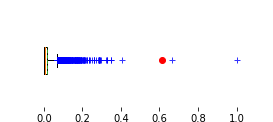
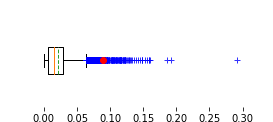
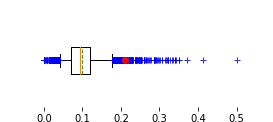
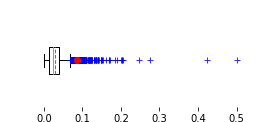
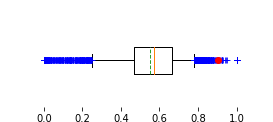

In [172]:
make_table(location='L83012',
           sort_asc=False,
           compare_with='nat',
           filter_level=0.01,
           num_results=5)

## Compared with own CCG

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.


,Chemical name,Subparagraph name,Numerator,Denominator,Ratio,Mean ratio,STDs from mean,Plot
0,Telmisartan,Angiotensin-II Receptor Antagonists,293,478,61.3%,1.9%,8.52,
1,Fexofenadine Hydrochloride,Antihistamines,102,243,42.0%,12.1%,4.87,
2,Salmeterol,Selective Beta(2)-Agonists,26,293,8.9%,2.7%,2.98,
3,Phenytoin Sodium,Control Of Epilepsy,25,288,8.7%,2.9%,2.83,
4,Warfarin Sodium,Oral Anticoagulants,388,430,90.2%,56.3%,2.38,

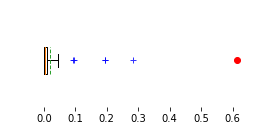
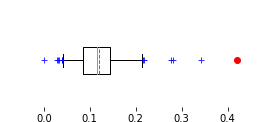
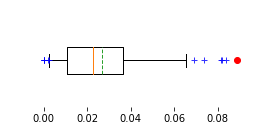
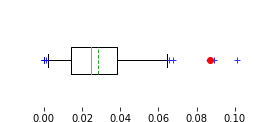
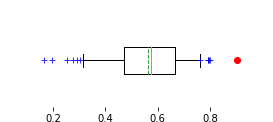

In [173]:
make_table(location='L83012',
           sort_asc=False,
           compare_with='ccg',
           filter_level=0.01,
           num_results=5)

## #nofilter

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.


,Chemical name,Subparagraph name,Numerator,Denominator,Ratio,Mean ratio,STDs from mean,Plot
0,Perindopril Arginine,Angiotensin-Converting Enzyme Inhibitors,146,789,18.5%,0.1%,25.60,
1,Telmisartan,Angiotensin-II Receptor Antagonists,293,478,61.3%,1.8%,17.23,
2,Lacosamide,Control Of Epilepsy,12,288,4.2%,0.5%,4.37,
3,Ciprofibrate,Lipid-Regulating Drugs,6,"1,233",0.5%,0.0%,3.41,
4,Salmeterol,Selective Beta(2)-Agonists,26,293,8.9%,2.1%,3.16,

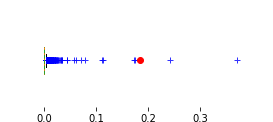
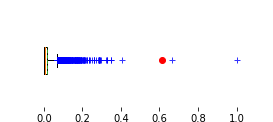
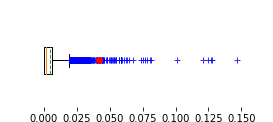
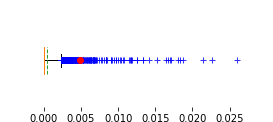
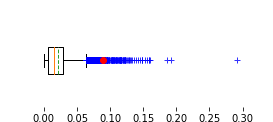

In [174]:
make_table(location='L83012',
           sort_asc=False,
           compare_with='nat',
           filter_level=0.0,
           num_results=5)

## CCG level

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.


,Chemical name,Subparagraph name,Numerator,Denominator,Ratio,Mean ratio,STDs from mean,Plot
0,Levofloxacin,Quinolones,778,"1,592",48.9%,7.1%,8.93,
1,Isophane Insulin,Intermediate And Long-Acting Insulins,"7,580","19,529",38.8%,12.5%,3.54,
2,Triptorelin Embonate,Prostate Cancer & Gonadorelin Analogues,332,"1,480",22.4%,3.9%,3.22,
3,Flumetasone Pivalate,Otitis Externa,615,"5,809",10.6%,4.4%,3.09,
4,Dexamethasone Sodium Metasulphobenzoate,Otitis Externa,716,"5,947",12.0%,5.9%,2.65,

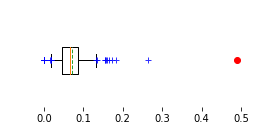
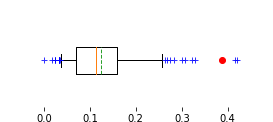
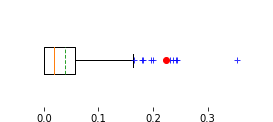
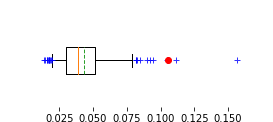
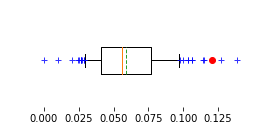

In [178]:
make_table(location='99P',
           sort_asc=False,
           ccg_prac_level=False,
           compare_with='nat',
           filter_level=0.01,
           num_results=5)

# DIFFERENT CHARTS

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.


,Chemical name,Subparagraph name,Numerator,Denominator,Ratio,Mean ratio,STDs from mean,Plot
0,Telmisartan,Angiotensin-II Receptor Antagonists,293,478,61.3%,1.8%,17.23,
1,Salmeterol,Selective Beta(2)-Agonists,26,293,8.9%,2.1%,3.16,
2,Sodium Valproate,Control Of Epilepsy,61,288,21.2%,9.9%,2.64,
3,Phenytoin Sodium,Control Of Epilepsy,25,288,8.7%,2.9%,2.49,
4,Warfarin Sodium,Oral Anticoagulants,388,430,90.2%,55.0%,2.12,

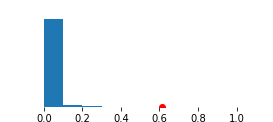
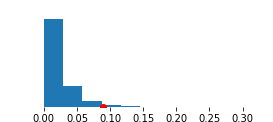
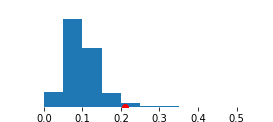
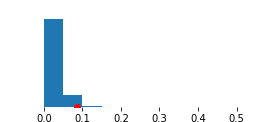
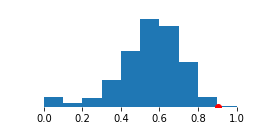

In [179]:
make_table(location='L83012',
           charttype='hist',
           sort_asc=False,
           ccg_prac_level=False,
           compare_with='nat',
           filter_level=0.01,
           num_results=5)

C:\Users\ajwalker\Anaconda2\lib\site-packages\ipykernel\__main__.py:76: PerformanceWarning: indexing past lexsort depth may impact performance.


,Chemical name,Subparagraph name,Numerator,Denominator,Ratio,Mean ratio,STDs from mean,Plot
0,Telmisartan,Angiotensin-II Receptor Antagonists,293,478,61.3%,1.8%,17.23,
1,Salmeterol,Selective Beta(2)-Agonists,26,293,8.9%,2.1%,3.16,
2,Sodium Valproate,Control Of Epilepsy,61,288,21.2%,9.9%,2.64,
3,Phenytoin Sodium,Control Of Epilepsy,25,288,8.7%,2.9%,2.49,
4,Warfarin Sodium,Oral Anticoagulants,388,430,90.2%,55.0%,2.12,

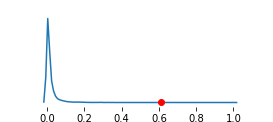
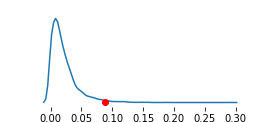
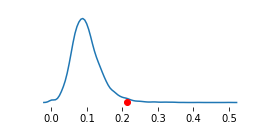
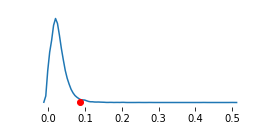
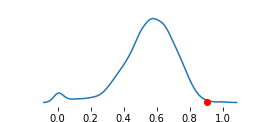

In [180]:
make_table(location='L83012',
           charttype='kdeplot',
           sort_asc=False,
           ccg_prac_level=False,
           compare_with='nat',
           filter_level=0.01,
           num_results=5)